### Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import csv
from scipy.optimize import minimize
from matplotlib.lines import Line2D

from utils import preprocess_data
from utils import normalize_scaled_curves
from utils import lorentzian_fit
from utils import lorentzian_fit_fix_b
from utils import optimize_T0_log


### Load scaled SAXS data, perform Lorentzian fit with fixed η on the global SAXS curve

In [12]:

with open('SAXS_Global_Scale.pickle', 'rb') as f:
    scaling_results = pickle.load(f)
    scaled_curves = pickle.load(f)

# Normalize the merged data
normalized_q, normalized_i = normalize_scaled_curves(scaled_curves)

# Filter out non-positive values to avoid NaN issues
valid_indices = normalized_q > 0
filtered_x = normalized_q[valid_indices]
filtered_y = normalized_i[valid_indices]

# Fit using scattering function with b fixed
popt, pcov = curve_fit(lorentzian_fit, filtered_x, filtered_y, 
                       p0=[np.max(filtered_y), 1, 1.7], bounds=([0, 0, 1], [np.inf, np.inf, 2]))

Iq0_fit, xi_fit, b_fit = popt
xi_fit_err = np.sqrt(np.diag(pcov))[1]
extended_x = np.linspace(filtered_x.min(), filtered_x.max(), 500)
fitted_y = lorentzian_fit_fix_b(extended_x, Iq0_fit, xi_fit)
scaled_x = filtered_x * xi_fit
extended_scaled_x = extended_x * xi_fit


In [14]:
print(b_fit)

1.38428410173064


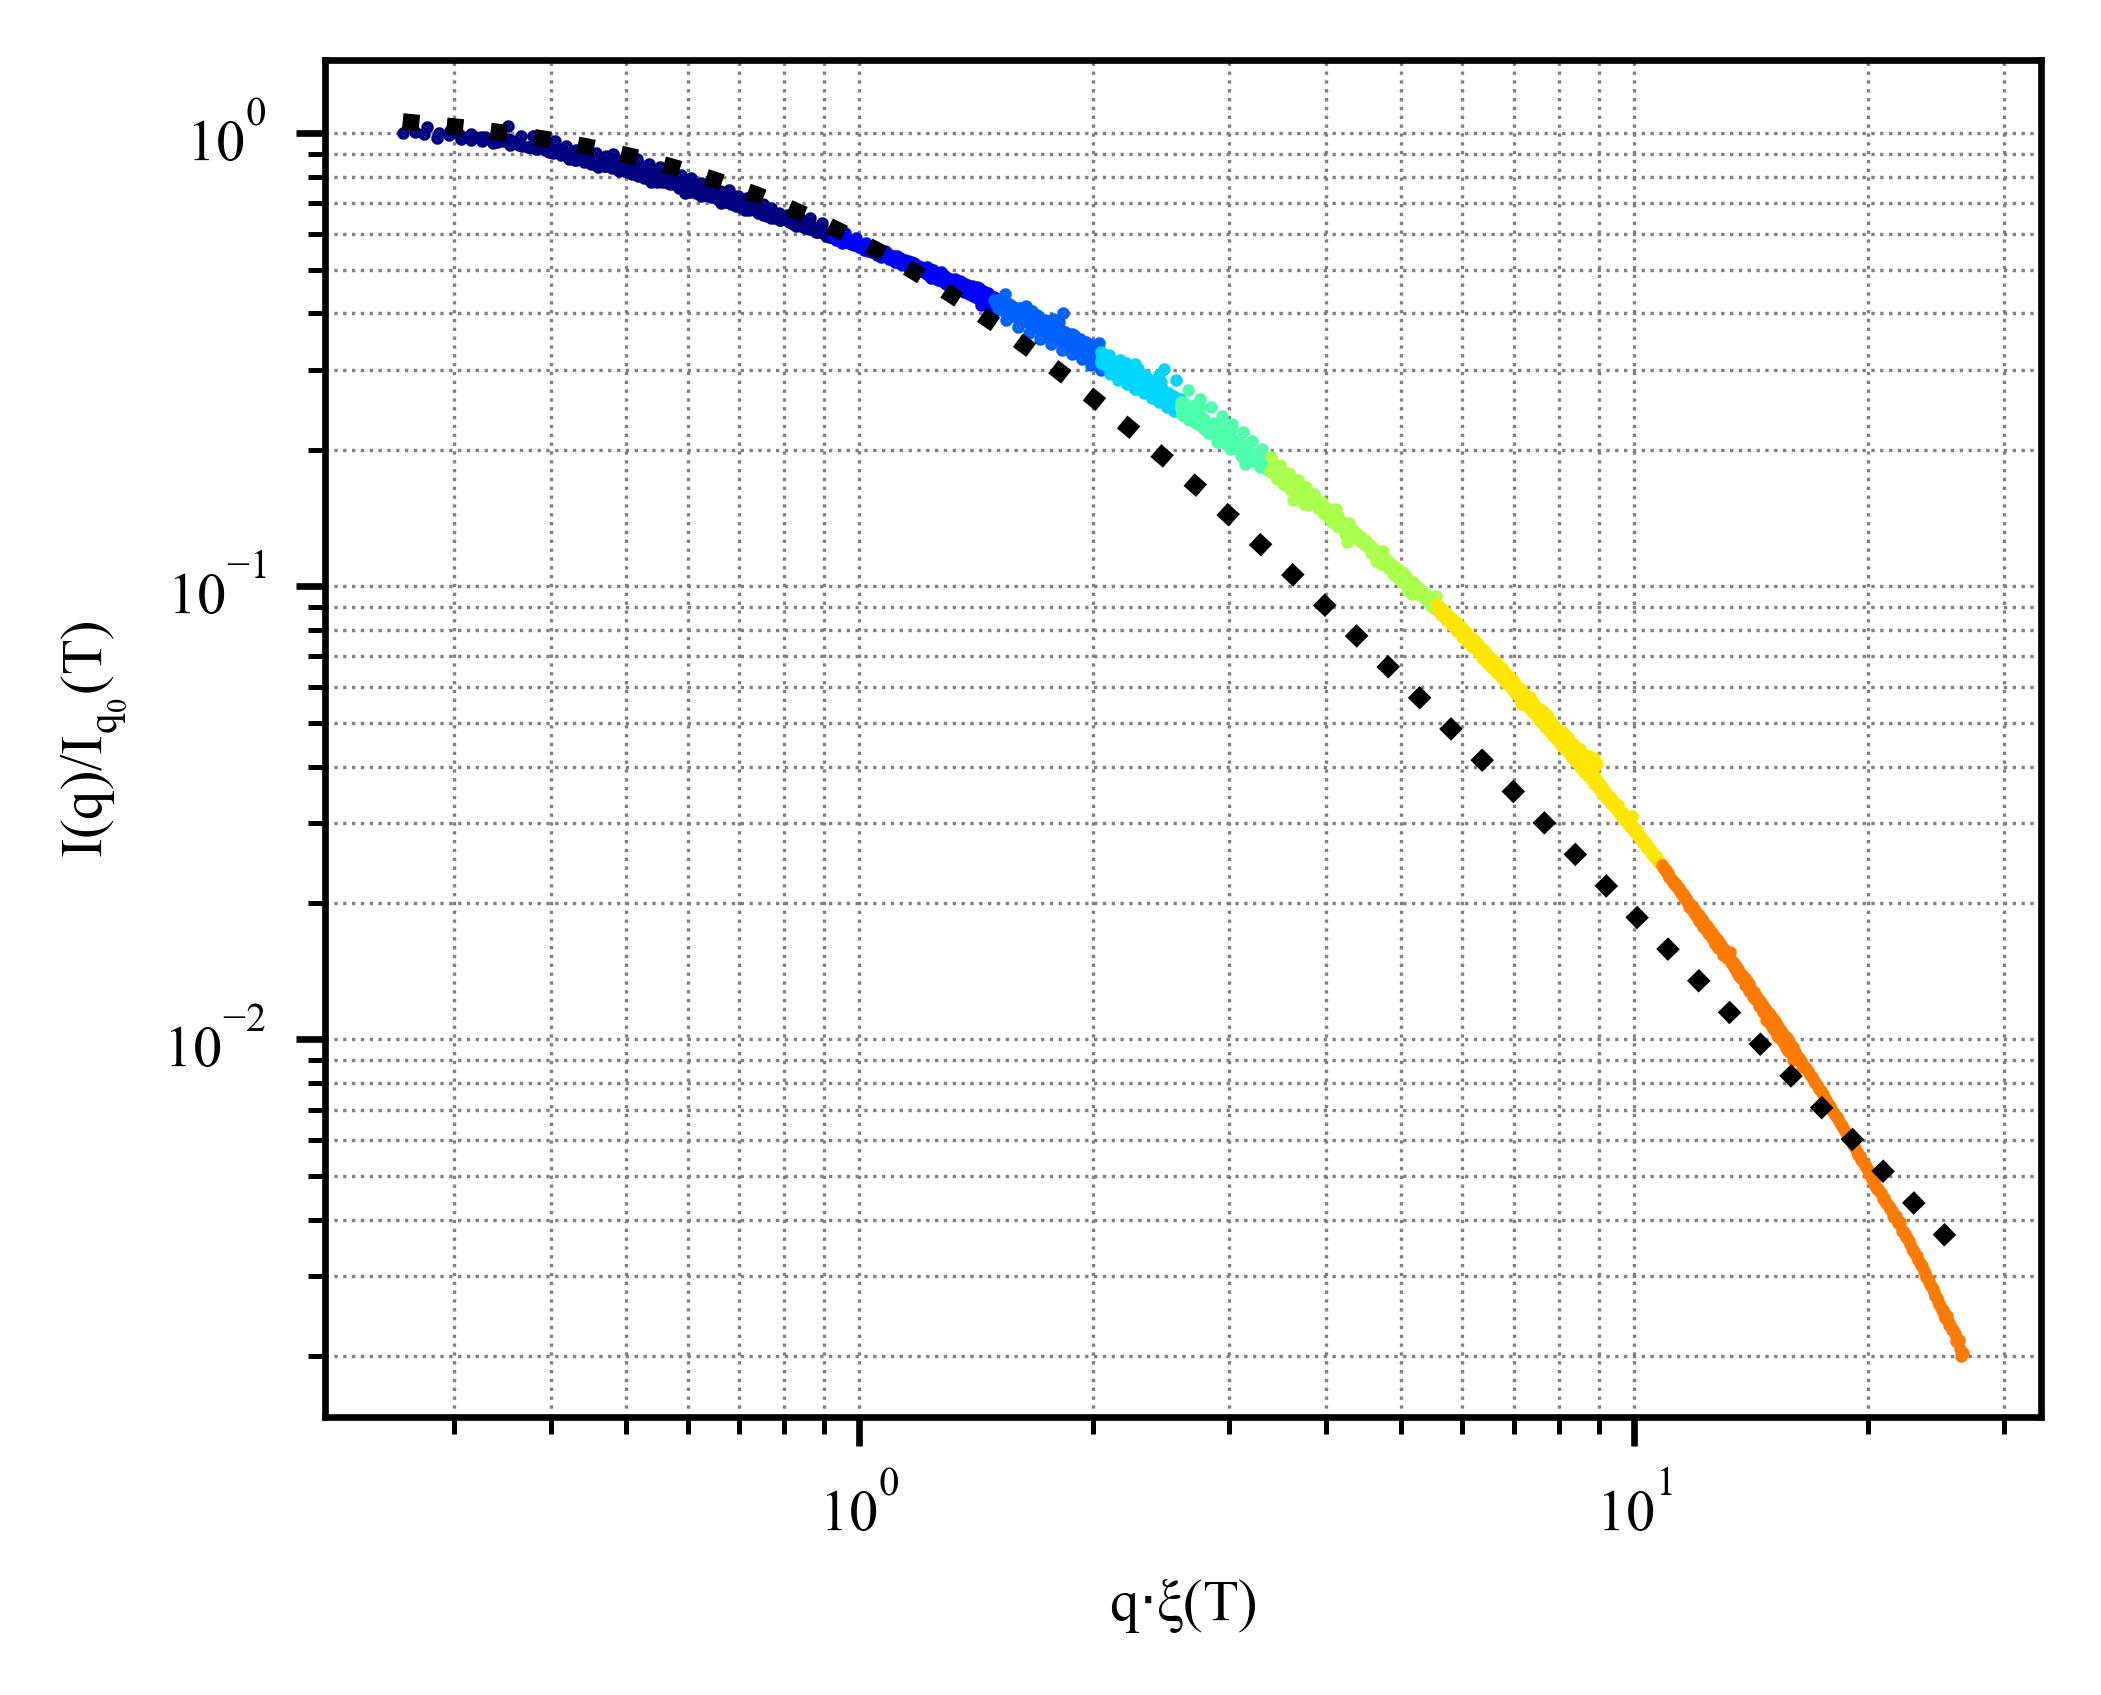

In [17]:

num_T = 9

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 600

cmap = plt.get_cmap('jet')
colors = [cmap(i / num_T) for i in range(num_T)]
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']

figure_width_mm = 86
figure_width_inches = figure_width_mm / 25.4

# --------------------------
# Plotting setup for main figure with 3 subplots
fig, ax = plt.subplots(figsize=(figure_width_inches, figure_width_inches * 0.8), constrained_layout=True)
for i in range(8):
    start_idx = i * 259
    end_idx = (i + 1) * 259
    ax.loglog(scaled_x[start_idx:end_idx], filtered_y[start_idx:end_idx], 'o', 
                    color=colors[i], markersize=0.5)
ax.loglog(extended_scaled_x, fitted_y, color='black', linewidth=2, linestyle=':')
ax.set_xlabel(r'q$\cdot\mathdefault{\xi(T)}$', fontsize=7)
ax.set_ylabel(r'I(q)/I$\mathdefault{_{q_0}(T)}$', fontsize=7)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
plt.figure(fig)
plt.show()
